# Introduction
In this assignment, you are going to train a neural network to **predict a likely language of origin for a last name**.


- Learn to preprocess raw text so it can be fed into an RNN and LSTM;
- Make use of relevant libraries in Pytorch;
- Train, evaluate, and generate predictions for unseen data.

Disclaimer: we’re using this dataset for academic purposes only. The model you train should not be used to draw any real-world conclusions about people’s names.



# Library imports

Before starting, make sure you have all these libraries.

In [44]:
# from google.colab import drive
# drive.mount('/content/drive')

In [45]:
# TODO: cd into the correct drive folder! Example:
%cd drive/MyDrive/hw3

[Errno 2] No such file or directory: 'drive/MyDrive/hw3'
/home/cleverctz/berkeley/cs182_deeplearning/hw4/hw4


In [46]:
root_folder = ""
import os
import sys
sys.path.append(root_folder)
import torch as th
from torch import nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
device = th.device("cuda" if th.cuda.is_available() else "cpu")
from sklearn.utils import shuffle

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part A. Creating the Network
The problem is predicting the $$ P ( class | c_1, c_2, c_3, ..., c_i), \forall i \in name $$

where c is each character in a name. The advantage of building this basic character-level NLP model is that you can see how preprocessing works at a low level. A character-level network reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

All models in PyTorch inherit from the subclass nn.Module. Here, you will intialize a custom model called RecurrentClassifier to run [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), among other nn functions you can find in the Pytorch docs, and define its forward function. Fill in the TODO's below. **Note: set batch_first in the arguments to the above to True.**

In [48]:
class RecurrentClassifier(nn.Module):
    def __init__(self, vocab_size, rnn_size, n_categories, model_type, num_layers=1, dropout=0):
        super().__init__()
        self.model_type = model_type
        # An embedding layer that will map our vocab into a vector of length rnn_size. 
        self.embedding = lambda x: nn.functional.one_hot(x, vocab_size).float()

        # Create an LSTM layer of rnn_size size. Use any features you wish.
        # We will be using batch_first convention
        if model_type == 'lstm':
            self.lstm = nn.LSTM(vocab_size, rnn_size, num_layers, batch_first=True)
        elif model_type == 'rnn':
            self.rnn = nn.RNN(vocab_size, rnn_size, num_layers, batch_first=True)
        # RNN/LSTM do not add dropout to the last hidden output, 
        # uncomment the line below if you wish.
        # self.dropout = nn.Dropout(p=dropout)

        # Final linear layer that projects the outputs of the RNN/LSTM into
        # logits of size n_categories
        self.output = nn.Linear(rnn_size, n_categories)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        '''
        Run input data x through each relevant layer depending on self.model_type,
        and output the final logits.
        '''
        embedded = self.embedding(x)# initialize
        if self.model_type =='lstm':
            after_rnn, (h_last, c_last) = self.lstm(embedded)
            out_put = self.output(after_rnn)

        elif self.model_type == 'rnn':
            after_rnn, all_h = self.rnn(embedded)
            out_put = self.output(after_rnn)
        
        # out = self.softmax(out_put)
        return out_put


# Part B: Preprocessing the dataset
The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand last names from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}. 

Fill in the TODO's in the following cells.


In [49]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt']
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [50]:
def letterToIndex(letter):
    '''
    Find letter index from all_letters, e.g. "a" returns 0
    '''
    # TODO
    asc = ord(letter)
    if asc >= ord('a') and asc<= ord('z'):
        value = asc - ord('a')
    if asc >= ord('A') and asc<= ord('Z'):
        value = asc - ord('A') + 26
    # else:
    #     value = asc - ord('A')
    if letter == ' ':
        value = 52
    if letter == '.':
        value = 53
    if letter == ',':
        value = 54
    if letter == ';':
        value = 55
    if letter == "'":
        value = 56
    return value

In [51]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())
pad = 57 # this is the next available character 
vocab_size = 58 # number of characters used in total

def build_data(category_lines):
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}. 

  We want to translate our dictionary into a dataset that has one entry per name. 
  Each datapoint is a 3-tuple consisting of: 
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index where the padding begins
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [52]:
data = build_data(category_lines)
# TODO: shuffle the dataset, then do train test split with 80% as train set.
random.shuffle(data)
train_data = data[0:int(.8*len(data))]
test_data = data[int(.8*len(data)):]

In [53]:
def one_hot_encoding(num):
    ans = np.zeros(n_categories)
    ans[num] = 1.
    return ans

# Part C: Training the models

Fill in the TODO's below. 

Training will be faster if you use the Colab GPU. If it's not already enabled, do so with Runtime -> Change runtime type.

Look at the training loss curves of RNN vs. LSTM. Which one does better? 

In [54]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch 
    of source and target elements from the dataset. See the next cell for 
    when and how it's used. 
    
    Arguments:
        dataset: List[db_element] -- A list of datapoints.
        Again, each datapoint is a 3-tuple consisting of: 
          - x: a length-19 array with each character in the name as an element,
          padded with zeros at the end if the name is less than 19 characters.
          - y: the numerical representation of the language the name corresponds to.
          - index: the index where the padding begins

        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: np.array[np.array[int]] -- List of tensorized names
        batch_target: np.array[int] -- List of numerical categories
        batch_indices: np.array[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    one_hot = lambda x: nn.functional.one_hot(x, n_categories)
    batch = [dataset[i] for i in indices]
    batch_input = np.array([batch[i][0] for i in range(len(batch))])
    batch_target = np.array([batch[i][1] for i in range(len(batch))])
    batch_indices = np.array([batch[i][2] for i in range(len(batch))])
    # TODO
    # batch_target = np.array([one_hot_encoding(batch_target[i]) for i in range(len(batch_target))])
    # print(batch_target)
    return batch_input, batch_target, batch_indices

In [55]:
criterion = nn.CrossEntropyLoss()# TODO: use Pytorch's cross-entropy loss.
def loss_fn(pred, target, index):
    '''
    Arguments:
      pred: tensor of shape (batch_size, 19, vocab_size), representing predictions
      for all 19 timesteps, one character per timestep
      target: labels of length batch_size
      index: indices of length batch_size
    Returns:
      Loss averaged acrosss the batch. The criterion already handles the averaging.
    '''
    # we just want to compute loss based on the prediction's last token
    pred_valid = pred[np.arange(len(pred)),index,:] 
    loss_tensor = criterion(pred_valid, target)# TODO: use criterion
    return loss_tensor

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types. 
batch_to_torch = lambda b_in,b_target,b_mask: (th.tensor(b_in).long(),
                                               th.tensor(b_target).long(), 
                                               th.tensor(b_mask).long())

# Model parameters. You can tune this for better performance. 
hidden_size = 512
num_layers = 2
dropout = .3
optimizer_class = optim.Adam
lr = 1e-3
epochs = 10
batch_size = 128

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

cuda


In [56]:
# invoke the model class you defined earlier. 
lstm_model = RecurrentClassifier(vocab_size = vocab_size, rnn_size = hidden_size,model_type='lstm', n_categories = n_categories, num_layers=num_layers)
lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)
rnn_model = RecurrentClassifier(vocab_size = vocab_size, rnn_size = hidden_size,model_type='rnn', n_categories = n_categories, num_layers=num_layers)
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [57]:
def train(model, optimizer, epochs, model_id='test_1'):
  '''
  Train and save a model.

  Make sure to save your latest model with a UNIQUE model name if you need to
  access it later! 
  '''
  model.train()
  losses = []
  accuracies = []
  from tqdm import tqdm
  for epoch in range(epochs):
      indices = np.random.permutation(range(len(train_data)))
      t = tqdm(range(0,(len(train_data)//batch_size)+1))
      for i in t:
          batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])# TODO: make a batch from training data, depending on iteration i and batch_size
          (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
          (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))
          model.to(device)
        #   print(batch_target)
          prediction = model(batch_input)# TODO
          loss = loss_fn(prediction, batch_target, batch_indices)# TODO
          losses.append(loss.item())
          pred_valid = prediction[np.arange(len(prediction)),batch_indices,:]
          accuracy = th.mean(th.eq(pred_valid.argmax(dim=1,keepdim=False),batch_target).float())
          accuracies.append(accuracy.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if i % 10 == 0:
              t.set_description(f"Epoch: {epoch} Iteration: {i} Loss: {np.mean(losses[-10:])} Accuracy: {np.mean(accuracies[-10:])}")
      os.makedirs(root_folder+'models/part1',exist_ok=True)        
      save_dict = dict(
          kwargs = dict(
              vocab_size=vocab_size,
              rnn_size=hidden_size,
              n_categories=n_categories,
              num_layers=num_layers,
              dropout=dropout
          ),
          model_state_dict = model.state_dict(),
          notes = "",
          optimizer_class = optimizer_class,
          lr = lr,
          epochs = epochs,
          batch_size = batch_size,
      )
      th.save(save_dict,root_folder+f'models/part1/model_{model_id}.pt')
  return losses

In [58]:
lstm_losses = train(lstm_model, lstm_optimizer, epochs, 'test_lstm')

Epoch: 0 Iteration: 120 Loss: 1.373689556121826 Accuracy: 0.61328125: 100%|██████████| 126/126 [00:02<00:00, 54.98it/s]
Epoch: 1 Iteration: 120 Loss: 1.0313877642154694 Accuracy: 0.7078125: 100%|██████████| 126/126 [00:02<00:00, 57.05it/s]     
Epoch: 2 Iteration: 120 Loss: 0.8973000526428223 Accuracy: 0.72265625: 100%|██████████| 126/126 [00:02<00:00, 57.12it/s]    
Epoch: 3 Iteration: 120 Loss: 0.8477613925933838 Accuracy: 0.7484375: 100%|██████████| 126/126 [00:02<00:00, 56.58it/s]     
Epoch: 4 Iteration: 120 Loss: 0.7533215999603271 Accuracy: 0.77578125: 100%|██████████| 126/126 [00:02<00:00, 56.61it/s]    
Epoch: 5 Iteration: 120 Loss: 0.6824279189109802 Accuracy: 0.7828125: 100%|██████████| 126/126 [00:02<00:00, 56.40it/s]     
Epoch: 6 Iteration: 120 Loss: 0.6083314299583436 Accuracy: 0.81484375: 100%|██████████| 126/126 [00:02<00:00, 55.51it/s]    
Epoch: 7 Iteration: 120 Loss: 0.525151914358139 Accuracy: 0.82578125: 100%|██████████| 126/126 [00:02<00:00, 55.55it/s]     
Epoch

In [59]:
rnn_losses = train(rnn_model, rnn_optimizer, epochs, 'test_rnn')

Epoch: 0 Iteration: 120 Loss: 1.0700339615345 Accuracy: 0.69453125: 100%|██████████| 126/126 [00:01<00:00, 122.96it/s]   
Epoch: 1 Iteration: 120 Loss: 0.9783098995685577 Accuracy: 0.70546875: 100%|██████████| 126/126 [00:01<00:00, 125.53it/s]
Epoch: 2 Iteration: 120 Loss: 0.8926216721534729 Accuracy: 0.73203125: 100%|██████████| 126/126 [00:01<00:00, 123.08it/s]
Epoch: 3 Iteration: 120 Loss: 0.8345666766166687 Accuracy: 0.74140625: 100%|██████████| 126/126 [00:01<00:00, 120.72it/s]
Epoch: 4 Iteration: 120 Loss: 0.713063657283783 Accuracy: 0.7703125: 100%|██████████| 126/126 [00:01<00:00, 124.18it/s]  
Epoch: 5 Iteration: 120 Loss: 0.6122567117214203 Accuracy: 0.81328125: 100%|██████████| 126/126 [00:01<00:00, 124.00it/s]
Epoch: 6 Iteration: 120 Loss: 0.6181397318840027 Accuracy: 0.81015625: 100%|██████████| 126/126 [00:01<00:00, 122.41it/s]
Epoch: 7 Iteration: 120 Loss: 0.6249564826488495 Accuracy: 0.80546875: 100%|██████████| 126/126 [00:00<00:00, 126.83it/s]
Epoch: 8 Iteration: 120 

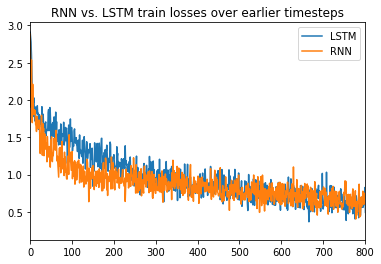

In [60]:
plt.title("RNN vs. LSTM train losses over earlier timesteps")
plt.plot(lstm_losses,label="LSTM")
plt.plot(rnn_losses, label="RNN")
plt.xlim([0,800])
plt.legend()

# Part D: Using the LSTM model

## (1) Evaluation loss

Load the model you trained, and obtain a test loss. Your objective is to reach a **LSTM validation loss <= 0.6**
You should not need more than 10 epochs to attain the threshold. More passes over the data can however give you a better model. Other options include changing your optimizers, tuning your learning_rate, and using the last dropout layer.
Fill in the TODO's.

In [86]:
model_id = "test_lstm" # Make sure this id matches the id you assigned the LSTM model
save_dict = th.load(root_folder+'models/part1/'+f"model_{model_id}.pt",)
model = RecurrentClassifier(**save_dict['kwargs'],model_type='lstm')
model.load_state_dict(save_dict['model_state_dict'])
model.eval()

RecurrentClassifier(
  (lstm): LSTM(58, 512, num_layers=2, batch_first=True)
  (output): Linear(in_features=512, out_features=18, bias=True)
)

In [87]:
# Make sure your validation loss is below 0.6 and that you didn't train using
# the test set.
indices = np.random.permutation(range(len(test_data)))
batch = build_batch(test_data, indices)# TODO: put entire test set into a batch
(batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
prediction = model(batch_input)# TODO
loss = loss_fn(prediction, batch_target, batch_indices)
print("Evaluation set loss:", loss.item())

Evaluation set loss: 0.5812450051307678


In [63]:
model.cpu()

RecurrentClassifier(
  (lstm): LSTM(58, 512, num_layers=2, batch_first=True)
  (output): Linear(in_features=512, out_features=18, bias=True)
)

## (2) Try some other names!
This time, obtain the output_logits from our model instead of the loss to predict on a name that you specify. Fill in the TODO's.

In [74]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the 
    predicted class.
    '''
    token = np.ones(19) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    logits = model(th.from_numpy(token.reshape(1,-1)).long())# TODO
    logits_np = logits.detach().cpu().numpy()
    return np.argmax(logits_np[0, n])# TODO

In [82]:
model.eval()
names= ['Sahai']
for name in names:
    print("===================")
    print("Predicting origin language for name: "+ name)
    c = classify_name(name, model)
    print(num_to_cat[c])

Predicting origin language for name: Sahai
Arabic


## Woooo! All done. 
